In [2]:
import os
import xml.etree.ElementTree as ET
import pandas as pd

# Path to annotation files
ANNOTATIONS_DIR = 'dataset/annotations'

# Initialize an empty list to store annotation values
data = []

# Parse all annotation files
for file in os.listdir(ANNOTATIONS_DIR):
    if not file.endswith('.xml'):
        continue
    tree = ET.parse(os.path.join(ANNOTATIONS_DIR, file))
    root = tree.getroot()
    filename = root.find('filename').text

    for obj in root.findall('object'):
        label = obj.find('name').text  
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        data.append([filename, label, xmin, ymin, xmax, ymax])

# Create DataFrame
df = pd.DataFrame(data, columns=['filename', 'severity', 'xmin', 'ymin', 'xmax', 'ymax'])

# Extract numeric part of filename for proper sorting
df['img_number'] = df['filename'].str.extract(r'img-(\d+)\.jpg').astype(int)

# Sort by image number
df_sorted = df.sort_values(by='img_number').reset_index(drop=True)

# Save it in a newly created csv files
df_sorted.to_csv('sorted_pothole_annotations.csv', index=False)

# Display first few rows
df_sorted.head()


,filename,severity,xmin,ymin,xmax,ymax,img_number
0,img-1.jpg,medium_pothole,213,240,525,378,1
1,img-2.jpg,medium_pothole,307,234,458,325,2
2,img-2.jpg,minor_pothole,264,299,363,382,2
3,img-2.jpg,minor_pothole,190,423,257,503,2
4,img-3.jpg,medium_pothole,273,264,497,468,3


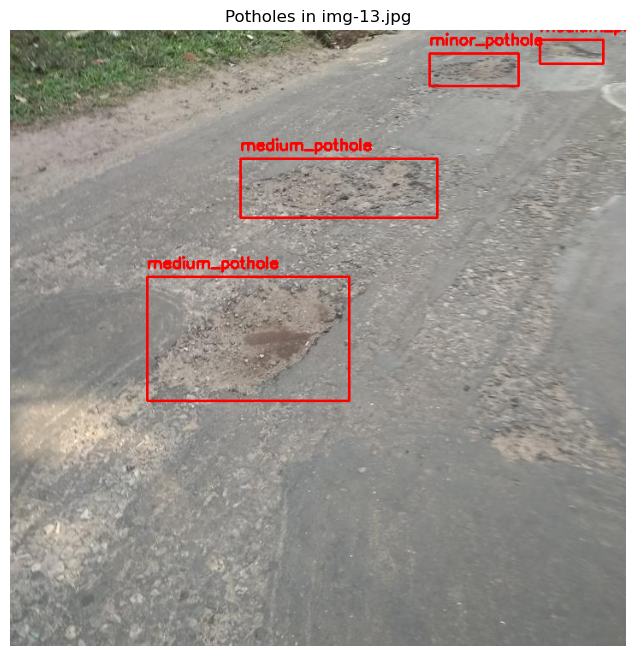

In [3]:
import cv2
import matplotlib.pyplot as plt

# Path to image files
IMAGES_DIR = 'dataset/images'

# Sample image filename
sample_filename = 'img-13.jpg'

# Load the image
img_path = os.path.join(IMAGES_DIR, sample_filename)
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display

# Get all rows in df for this image
boxes = df_sorted[df_sorted['filename'] == sample_filename]

# Draw boxes
for _, row in boxes.iterrows():
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
    label = row['severity']
    
    # Draw rectangle
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
    
    # Draw label text
    cv2.putText(image, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

# Show the image
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.axis('off')
plt.title(f'Potholes in {sample_filename}')
plt.show()


In [4]:
import os
import cv2
import matplotlib.pyplot as plt

# Paths
IMAGES_DIR = 'dataset/images'
OUTPUT_DIR = 'annotatedImages'

# Create output folder if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Go through each unique image in the DataFrame
for filename in df_sorted['filename'].unique():
    img_path = os.path.join(IMAGES_DIR, filename)
    image = cv2.imread(img_path)

    if image is None:
        print(f"Warning: Image not found - {filename}")
        continue

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get all bounding boxes for this image
    boxes = df_sorted[df_sorted['filename'] == filename]

    for _, row in boxes.iterrows():
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        label = row['severity']
        
        # Draw rectangle and label
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        cv2.putText(image, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    # Save the image
    output_path = os.path.join(OUTPUT_DIR, filename)
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Convert back to BGR for saving
    cv2.imwrite(output_path, image_bgr)

print(f"✅ Saved all visualized images to: {OUTPUT_DIR}")


✅ Saved all visualized images to: annotatedImages


severity
minor_pothole     418
medium_pothole    869
major_pothole     600
Name: count, dtype: int64


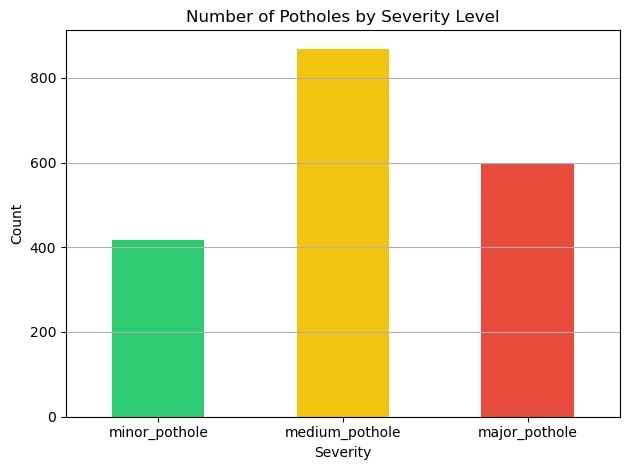

In [5]:
import matplotlib.pyplot as plt

# Count the number of occurrences for each severity level
severity_order = ['minor_pothole', 'medium_pothole', 'major_pothole']
severity_counts = df_sorted['severity'].value_counts().reindex(severity_order)
print(severity_counts)

# Define custom colors for each severity level
severity_colors = {
    'minor_pothole': '#2ecc71',   # Green
    'medium_pothole': '#f1c40f',  # Yellow
    'major_pothole': '#e74c3c'    # Red
}

# Create a list of colors in the same order as the bar chart
color_list = [severity_colors[severity] for severity in severity_counts.index]

# Plot the bar chart of severity levels
severity_counts.plot(kind='bar', color=color_list)
plt.title('Number of Potholes by Severity Level')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


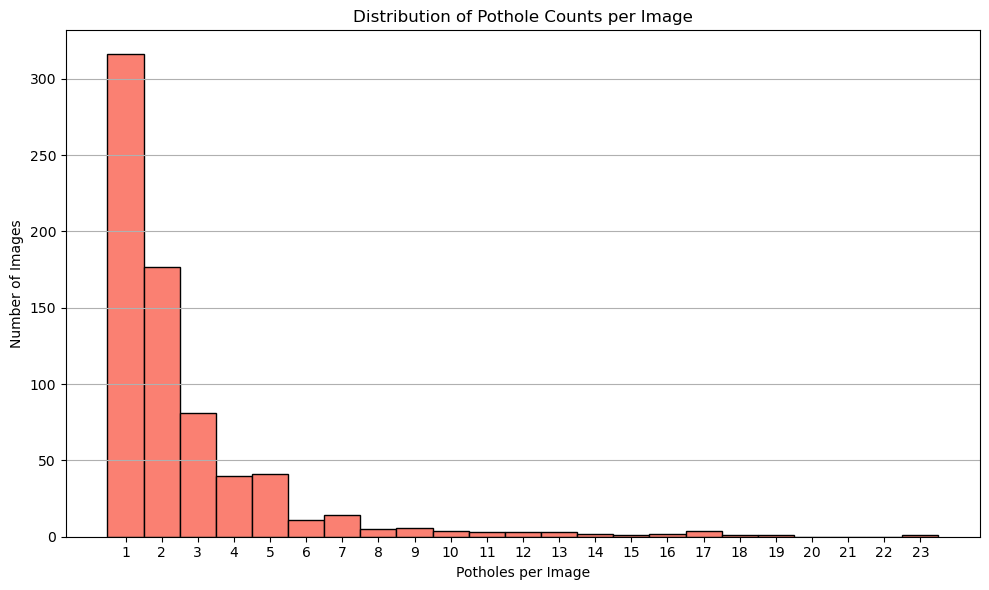

In [6]:
import matplotlib.pyplot as plt

# Histogram of potholes per image
potholes_per_image = df_sorted.groupby('filename').size()

# Create histogram with custom bins
bins = range(1, potholes_per_image.max() + 2)  # +2 so the last bin includes max value
plt.figure(figsize=(10, 6))
plt.hist(potholes_per_image, bins=bins, color='salmon', edgecolor='black', align='left')

# Set title and labels
plt.title('Distribution of Pothole Counts per Image')
plt.xlabel('Potholes per Image')
plt.ylabel('Number of Images')
plt.grid(axis='y')

# Show all integer ticks on x-axis
plt.xticks(bins[:-1])  # Exclude the last bin edge from labels

plt.tight_layout()
plt.show()


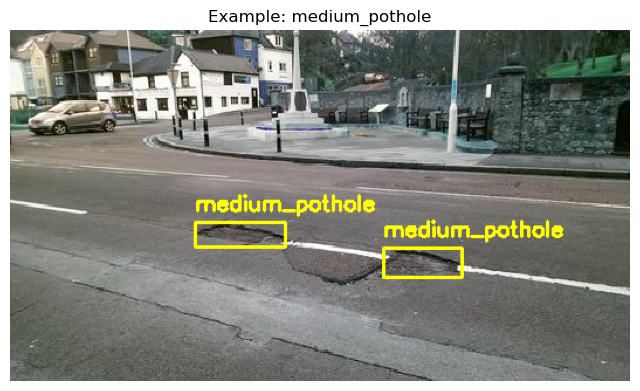

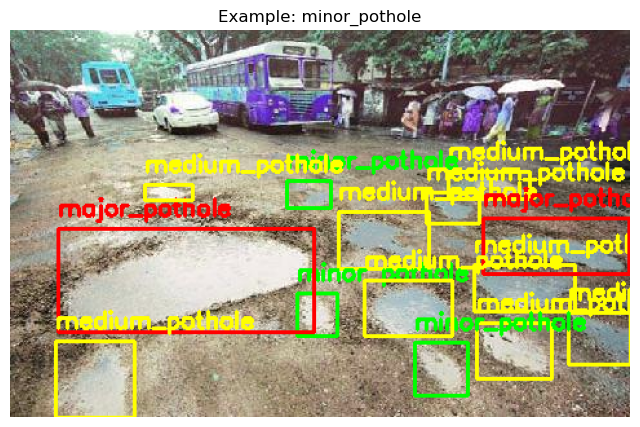

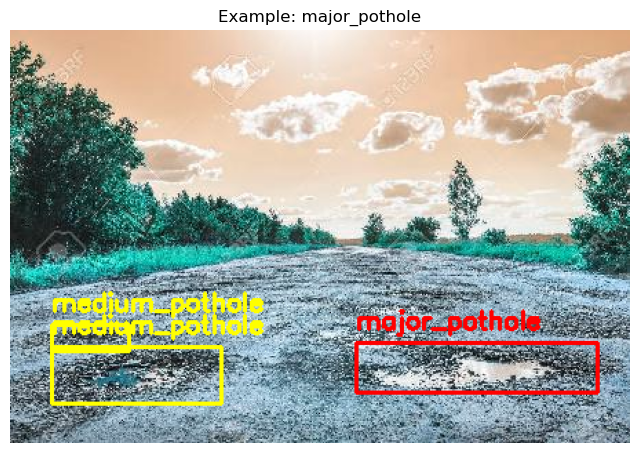

In [12]:
# Define custom colors for each severity level (in BGR for OpenCV)
severity_colors = {
    'minor_pothole': (0, 255, 0),    # Green
    'medium_pothole': (0, 255, 255), # Yellow (BGR for yellow)
    'major_pothole': (0, 0, 255)     # Red
}

# Loop through each unique severity level
for severity in df_sorted['severity'].unique():
    
    # Get the first image filename with this severity
    sample_row = df_sorted[df_sorted['severity'] == severity].sample(1).iloc[0]
    filename = sample_row['filename']
    
    # Load and convert the image
    image_path = os.path.join(IMAGES_DIR, filename)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get all boxes for this image
    boxes = df_sorted[df_sorted['filename'] == filename]
    
    # Draw boxes and labels with severity-specific colors
    for _, row in boxes.iterrows():
        box_color = severity_colors.get(row['severity'], (255, 255, 255))  # Default to white if missing
        cv2.rectangle(image, (row['xmin'], row['ymin']), (row['xmax'], row['ymax']), box_color, 2)
        cv2.putText(image, row['severity'], (row['xmin'], row['ymin'] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, box_color, 2)

    # Show the image
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Example: {severity}")
    plt.axis('off')
    plt.show()


In [8]:
# Map each unique severity label to a numeric class ID
classes = sorted(df_sorted['severity'].unique())
class_to_id = {cls: i for i, cls in enumerate(classes)}
print(class_to_id)

{'major_pothole': 0, 'medium_pothole': 1, 'minor_pothole': 2}


In [9]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
BASE_DIR = 'dataset'
IMAGE_INPUT_DIR = 'dataset/images'
os.makedirs(BASE_DIR, exist_ok=True)

# Create directories
for split in ['train', 'val']:
    os.makedirs(os.path.join(BASE_DIR, 'images', split), exist_ok=True)
    os.makedirs(os.path.join(BASE_DIR, 'labels', split), exist_ok=True)

# Split filenames
filenames = df_sorted['filename'].unique()
train_files, val_files = train_test_split(filenames, test_size=0.2, random_state=42)

split_map = {fname: 'train' if fname in train_files else 'val' for fname in filenames}

# Write YOLO labels
for filename in filenames:
    split = split_map[filename]
    image_path = os.path.join(IMAGE_INPUT_DIR, filename)
    label_path = os.path.join(BASE_DIR, 'labels', split, filename.replace('.jpg', '.txt'))

    image = cv2.imread(image_path)
    if image is None:
        print(f"Skipping {filename} — image not found.")
        continue
    height, width = image.shape[:2]

    rows = df_sorted[df_sorted['filename'] == filename]
    with open(label_path, 'w') as f:
        for _, row in rows.iterrows():
            class_id = class_to_id[row['severity']]
            # Normalize coordinates
            x_center = (row['xmin'] + row['xmax']) / 2 / width
            y_center = (row['ymin'] + row['ymax']) / 2 / height
            bbox_width = (row['xmax'] - row['xmin']) / width
            bbox_height = (row['ymax'] - row['ymin']) / height
            f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")

    # Copy image to correct split folder
    shutil.copy(image_path, os.path.join(BASE_DIR, 'images', split, filename))

print("✅ YOLO-format data saved in 'dataset/' folder.")


✅ YOLO-format data saved in 'dataset/' folder.
